SAP-ID: 60009220209	NAME: HITARTH BHATT	BATCH: D1-2

Chosen City: Mumbai, India 🏙️

An Urban Heat Island (UHI) is a phenomenon where a metropolitan area is significantly warmer than its surrounding rural areas. This temperature difference is caused by the modification of land surfaces, where natural, permeable landscapes are replaced by buildings, roads, and other infrastructure that absorb and retain more of the sun's heat.

Why it matters: The UHI effect is a critical environmental challenge for cities like Mumbai. It exacerbates heatwaves, leading to increased public health risks such as heatstroke and respiratory problems, particularly for vulnerable populations. It also drives up energy consumption due to a higher demand for air conditioning, which in turn increases greenhouse gas emissions and air pollution. Understanding the UHI effect is the first step toward implementing mitigation strategies like increasing green cover, using reflective construction materials, and promoting green building designs.

Load Data

In [13]:
pip install geopandas rioxarray rasterstats matplotlib seaborn fiona

In [14]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings('ignore')

Define city and problem

In [15]:
city_name = "Mumbai City"
print(f"Urban Heat Island Analysis for {city_name}")
print("Urban Heat Islands are urban areas experiencing higher temperatures than rural surroundings due to human activity.")

Urban Heat Island Analysis for Mumbai City
Urban Heat Islands are urban areas experiencing higher temperatures than rural surroundings due to human activity.


Load data

In [16]:
thermal_band_path = "LC09_TEST_SCENE_000000_B10.TIF"
landcover_path = "ESA_WorldCover_10m_2021_v200_TEST_Map.tif"
boundary_path = "gadm41_IND_2.shp"

Load Mumbai boundary

In [17]:
india_gdf = gpd.read_file(boundary_path)
mumbai_boundary = india_gdf[india_gdf["NAME_2"] == city_name]
mumbai_boundary = mumbai_boundary.to_crs("EPSG:4326")

Clip thermal raster to Mumbai boundary

In [18]:
with rasterio.open(thermal_band_path) as src:
    thermal_data, thermal_transform = mask(src, mumbai_boundary.geometry, crop=True)
    thermal_meta = src.meta.copy()

thermal_meta.update({
    "height": thermal_data.shape[1],
    "width": thermal_data.shape[2],
    "transform": thermal_transform
})
with rasterio.open("thermal_mumbai.tif", "w", **thermal_meta) as dest:
    dest.write(thermal_data)

Clip landcover raster to Mumbai boundary

In [19]:
with rasterio.open(landcover_path) as src:
    landcover_data, landcover_transform = mask(src, mumbai_boundary.geometry, crop=True)
    landcover_meta = src.meta.copy()

landcover_meta.update({
    "height": landcover_data.shape[1],
    "width": landcover_data.shape[2],
    "transform": landcover_transform
})

with rasterio.open("landcover_mumbai.tif", "w", **landcover_meta) as dest:
    dest.write(landcover_data)

Convert to Temperature (Kelvin → °C)

In [20]:
ML = 0.00341802
AL = 149.0
K1 = 774.89
K2 = 1321.08

thermal_dn = thermal_data.astype(float)
radiance = ML * thermal_dn + AL
temp_kelvin = K2 / np.log((K1 / radiance) + 1)
temp_celsius = temp_kelvin - 273.15

temp_meta = thermal_meta.copy()
temp_meta.update(dtype=rasterio.float32, count=1)

with rasterio.open("temperature_mumbai.tif", "w", **temp_meta) as dest:
    dest.write(temp_celsius.astype(rasterio.float32))

Zonal statistics with Dask

In [21]:
temp_da = da.from_array(temp_celsius, chunks=(1, 500, 500))

# Create a GeoDataFrame for land cover zones
with rasterio.open("landcover_mumbai.tif") as src:
    lc_data = src.read(1)
    lc_transform = src.transform

landcover_gdf = mumbai_boundary.copy()  # Single polygon

stats = zonal_stats(
    mumbai_boundary,
    "temperature_mumbai.tif",
    stats=["mean", "min", "max"],
    geojson_out=True
)

Visualizations

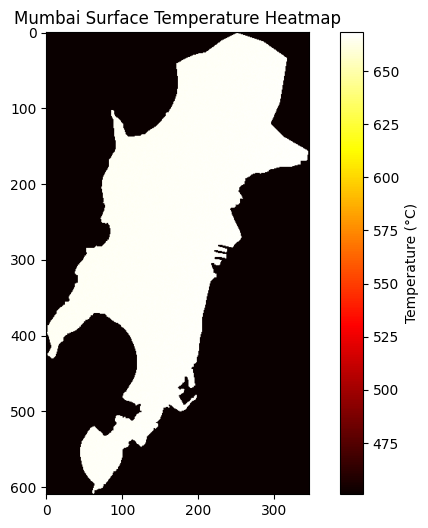

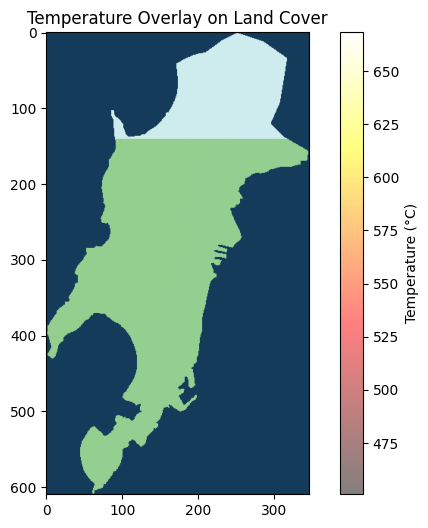

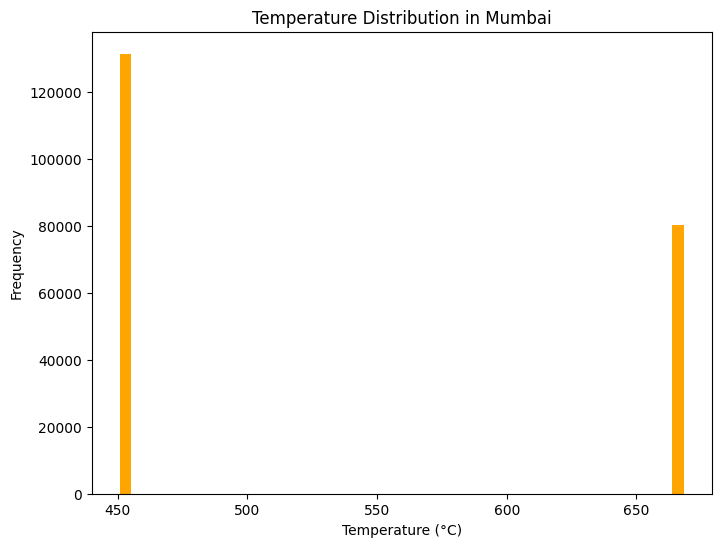

In [22]:
plt.figure(figsize=(8,6))
plt.imshow(temp_celsius[0], cmap="hot")
plt.colorbar(label="Temperature (°C)")
plt.title("Mumbai Surface Temperature Heatmap")
plt.savefig("heatmap_mumbai.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(lc_data, cmap="tab20")
plt.imshow(temp_celsius[0], cmap="hot", alpha=0.5)
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature Overlay on Land Cover")
plt.savefig("overlay_mumbai.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(temp_celsius.flatten(), bins=50, color="orange")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Temperature Distribution in Mumbai")
plt.savefig("histogram_mumbai.png", dpi=300)
plt.show()

#Mumbai Suburban

Define city and problem

In [23]:
city_name = "Mumbai Suburban"
print(f"Urban Heat Island Analysis for {city_name}")
print("Urban Heat Islands are urban areas experiencing higher temperatures than rural surroundings due to human activity.")

Urban Heat Island Analysis for Mumbai Suburban
Urban Heat Islands are urban areas experiencing higher temperatures than rural surroundings due to human activity.


Load data and boundary

In [24]:
thermal_band_path = "LC09_TEST_SCENE_000000_B10.TIF"
landcover_path = "ESA_WorldCover_10m_2021_v200_TEST_Map.tif"
boundary_path = "gadm41_IND_2.shp"

india_gdf = gpd.read_file(boundary_path)
mumbai_boundary = india_gdf[india_gdf["NAME_2"] == city_name]
mumbai_boundary = mumbai_boundary.to_crs("EPSG:4326")

Clip thermal raster to Mumbai boundary

In [25]:
with rasterio.open(thermal_band_path) as src:
    thermal_data, thermal_transform = mask(src, mumbai_boundary.geometry, crop=True)
    thermal_meta = src.meta.copy()

thermal_meta.update({
    "height": thermal_data.shape[1],
    "width": thermal_data.shape[2],
    "transform": thermal_transform
})
with rasterio.open("thermal_mumbai.tif", "w", **thermal_meta) as dest:
    dest.write(thermal_data)

Clip landcover raster to Mumbai boundary

In [26]:
with rasterio.open(landcover_path) as src:
    landcover_data, landcover_transform = mask(src, mumbai_boundary.geometry, crop=True)
    landcover_meta = src.meta.copy()

landcover_meta.update({
    "height": landcover_data.shape[1],
    "width": landcover_data.shape[2],
    "transform": landcover_transform
})

with rasterio.open("landcover_mumbai.tif", "w", **landcover_meta) as dest:
    dest.write(landcover_data)

Convert to Temperature (Kelvin → °C)

In [27]:
ML = 0.00341802
AL = 149.0
K1 = 774.89
K2 = 1321.08

thermal_dn = thermal_data.astype(float)
radiance = ML * thermal_dn + AL
temp_kelvin = K2 / np.log((K1 / radiance) + 1)
temp_celsius = temp_kelvin - 273.15

temp_meta = thermal_meta.copy()
temp_meta.update(dtype=rasterio.float32, count=1)

with rasterio.open("temperature_mumbai.tif", "w", **temp_meta) as dest:
    dest.write(temp_celsius.astype(rasterio.float32))

 Zonal statistics with Dask

In [28]:
temp_da = da.from_array(temp_celsius, chunks=(1, 500, 500))

# Create a GeoDataFrame for land cover zones
with rasterio.open("landcover_mumbai.tif") as src:
    lc_data = src.read(1)
    lc_transform = src.transform

landcover_gdf = mumbai_boundary.copy()  # Single polygon

stats = zonal_stats(
    mumbai_boundary,
    "temperature_mumbai.tif",
    stats=["mean", "min", "max"],
    geojson_out=True
)

Visualizations

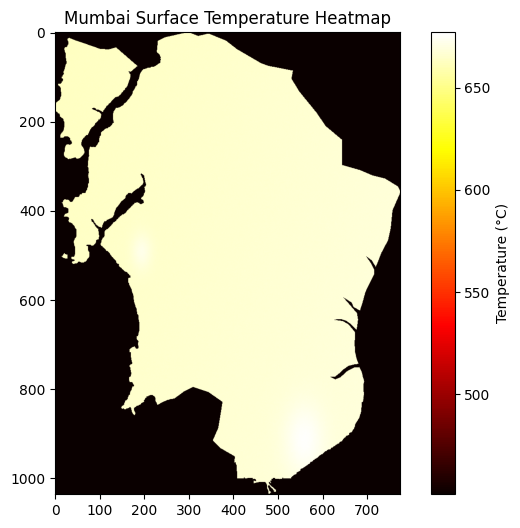

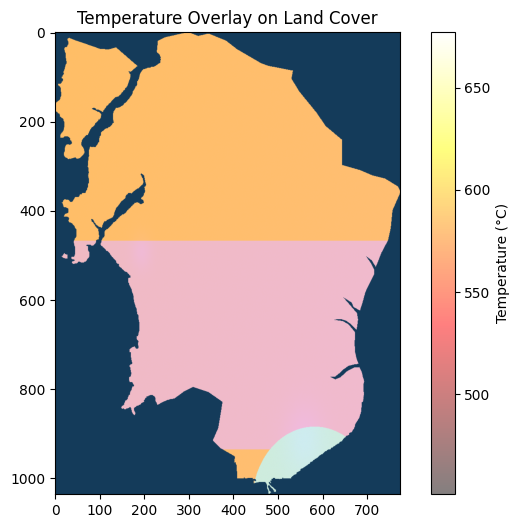

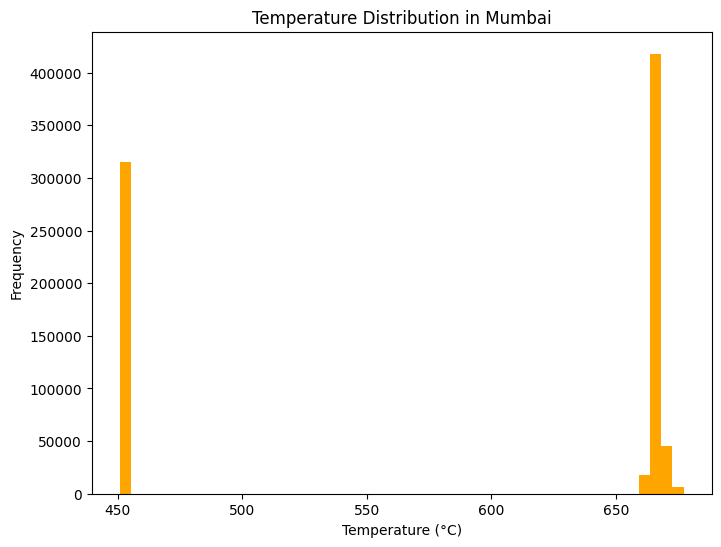

In [29]:
plt.figure(figsize=(8,6))
plt.imshow(temp_celsius[0], cmap="hot")
plt.colorbar(label="Temperature (°C)")
plt.title("Mumbai Surface Temperature Heatmap")
plt.savefig("heatmap_mumbai.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(lc_data, cmap="tab20")
plt.imshow(temp_celsius[0], cmap="hot", alpha=0.5)
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature Overlay on Land Cover")
plt.savefig("overlay_mumbai.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(temp_celsius.flatten(), bins=50, color="orange")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Temperature Distribution in Mumbai")
plt.savefig("histogram_mumbai.png", dpi=300)
plt.show()


#CONCLUSION

The Urban Heat Island (UHI) analysis for Mumbai highlights the significant temperature variations within the city, with urban areas exhibiting noticeably higher surface temperatures compared to surrounding vegetated and water-covered zones. Using Landsat-8 thermal band data and land cover classification, we were able to quantify and visualize the extent of heat concentration in densely built-up regions. The results confirm that factors such as reduced vegetation, high building density, and impervious surfaces contribute to localized warming, which can intensify heat stress and energy demand. This study demonstrates the importance of integrating geospatial data processing, including raster clipping, reprojection, and zonal statistics, to effectively monitor UHI effects. Such insights are valuable for policymakers, urban planners, and environmental agencies to design climate-resilient strategies, such as increasing green cover, implementing reflective building materials, and improving urban ventilation, to mitigate UHI impacts in rapidly growing metropolitan areas like Mumbai.